In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('feature_data.csv', index_col=0)
data.dropna(inplace=True)

# original shape is 53845 so 11427 rows with Nan's
# could try back/forward-filling to improve model performance
# with more kept data

data.shape

(42418, 49)

# Feature Selection
Use Recursive Feature Elimination to select an optimal subset of features.

In [3]:
X, y = data.drop('target', axis=1), data['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# normalize all of the columns
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X_train.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns = list(X.columns))
X_scaled.head()

,Useful,Cool,Funny,Bus_Ave_Star,User_Review_count,User_Useful_count,User_Funny_count,User_Cool_count,User_Fans,Users_Ave_Star,...,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37
0,-0.400972,-0.323647,-0.311805,-1.669866,-0.352567,-0.296032,-0.267627,-0.285993,-0.351219,-0.362147,...,-1.395348,0.292523,0.272443,-0.744305,-0.069176,1.214618,-1.370669,0.171317,-0.181786,-0.993078
1,-0.164486,-0.323647,-0.123632,0.075291,-0.435893,-0.370659,-0.297363,-0.327076,-0.459724,-1.299254,...,1.052607,0.337075,0.474454,-0.619009,-0.170364,-0.123836,-0.396163,0.144740,-0.527595,-0.809932
2,0.190243,-0.197643,-0.123632,-1.669866,0.018090,-0.308641,-0.263254,-0.296926,-0.356645,-0.537855,...,0.344104,-0.154971,0.095922,0.480437,-0.713832,0.123307,1.547221,-0.734104,-0.215047,0.877633
3,-0.282729,-0.323647,-0.311805,0.075291,-0.589616,-0.349547,-0.304360,-0.327076,-0.389196,-0.801416,...,2.870359,0.479456,-2.305962,0.556787,-1.468661,1.928297,-0.835789,1.403522,1.584039,-2.115051
4,9.767933,10.638748,12.107606,-2.542444,-0.233325,3.787467,3.812994,4.239769,3.516967,0.457822,...,-0.337045,0.073751,-1.516841,1.152527,-0.660889,-1.343177,-0.015457,-2.437355,3.727537,-0.007040


In [6]:
# rfecv to do feature selection
# grid search over number of features argument to get optimal # of features to keep in the end
# train rfecv with LR and then assume subset of features are the best for all models since LR,
# LDA, etc. are similar models and variables chosen through training with other models
# will mostly likely be very similar

In [7]:
#Stratified 10-fold cross validation
#using stratified ensure that each fold of dataset has the same proportion of observations with a given label
cv = StratifiedKFold(10)
rfecv = RFECV(LogisticRegression(max_iter=1000), cv=cv, scoring='f1_weighted')
rfecv.fit(X_scaled, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(max_iter=1000), scoring='f1_weighted')

Optimal number of features : 42
Best features : Index(['Useful', 'Cool', 'Funny', 'Bus_Ave_Star', 'User_Useful_count',
       'User_Funny_count', 'User_Cool_count', 'User_Fans', 'Users_Ave_Star',
       'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc9', 'pc11', 'pc12',
       'pc13', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22',
       'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31',
       'pc32', 'pc33', 'pc34', 'pc35', 'pc36'],
      dtype='object')
Original features : Index(['Useful', 'Cool', 'Funny', 'Bus_Ave_Star', 'User_Review_count',
       'User_Useful_count', 'User_Funny_count', 'User_Cool_count', 'User_Fans',
       'Users_Ave_Star', 'Elite_Count', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5',
       'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14',
       'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23',
       'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32',
       'pc33', 'pc

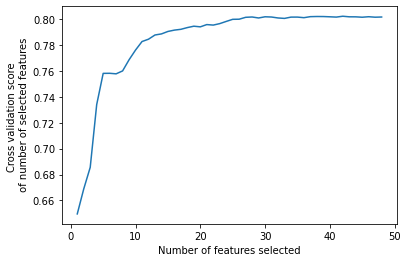

In [8]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [9]:
optimal_features = X_scaled.loc[:, rfecv.support_] # selector is a RFECV fitted object

n = 12 # to select top 6 features
feature_ranks = rfecv.ranking_  # selector is a RFECV fitted object
feature_ranks_with_idx = enumerate(feature_ranks)
sorted_ranks_with_idx = sorted(feature_ranks_with_idx, key=lambda x: x[1])
top_n_idx = [idx for idx, rnk in sorted_ranks_with_idx[:n]]

top_n_features = X_scaled.iloc[:, top_n_idx]
top_n_features.columns

Index(['Useful', 'Cool', 'Funny', 'Bus_Ave_Star', 'User_Useful_count',
       'User_Funny_count', 'User_Cool_count', 'User_Fans', 'Users_Ave_Star',
       'pc1', 'pc2', 'pc3'],
      dtype='object')

# Logistic Regression

In [14]:
lr = LogisticRegression(random_state=0).fit(top_n_features, y_train)

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, top_n_features, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.79158249 0.79124579 0.79016504 0.80161671 0.7942068  0.79184911
 0.79555406 0.80195352 0.79050185 0.78208151]


In [10]:
# predict using LR on test set
X_test_scaled = std_scaler.transform(X_test.to_numpy())
X_test_scaled = pd.DataFrame(X_test_scaled, columns = list(X_test.columns))

Index(['Useful', 'Cool', 'Funny', 'Bus_Ave_Star', 'User_Useful_count',
       'User_Funny_count', 'User_Cool_count', 'User_Fans', 'Users_Ave_Star',
       'pc1', 'pc2', 'pc3'],
      dtype='object')

In [15]:
lr.score(X_test_scaled.iloc[:, top_n_idx], y_test)

0.789014615747289

In [19]:
cm = confusion_matrix(lr.predict(X_test_scaled.iloc[:, top_n_idx]), y_test)
TN, FP, FN, TP = cm.ravel()
cm

array([[1001,  542],
       [2143, 9040]])

In [21]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TPR, TNR, FPR, FNR)

0.808369847089332 0.6487362281270252 0.35126377187297475 0.19163015291066798


# LDA

In [24]:
lda = LDA()
lda.fit(top_n_features, y_train)

LinearDiscriminantAnalysis()

In [25]:
scores = cross_val_score(lda, top_n_features, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.78686869 0.78922559 0.78544965 0.7989222  0.7965645  0.79016504
 0.79151229 0.79488043 0.78982822 0.78342876]


In [26]:
lda.score(X_test_scaled.iloc[:, top_n_idx], y_test)

0.7872858714442873

# QDA

In [29]:
qda = QDA()
qda.fit(top_n_features, y_train)

QuadraticDiscriminantAnalysis()

In [30]:
scores = cross_val_score(qda, top_n_features, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.76801347 0.77306397 0.75682048 0.77265072 0.77366117 0.77366117
 0.77164028 0.77972381 0.76591445 0.76288313]


In [31]:
qda.score(X_test_scaled.iloc[:, top_n_idx], y_test)

0.7706270627062707